# **Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

## **Edición 2023**


## Análisis exploratorio y curación de datos

### Trabajo práctico entregable - Grupo 22 - Parte 2

**Integrantes:**
- Chevallier-Boutell, Ignacio José
- Ribetto, Federico Daniel
- Rosa, Santiago
- Spano, Marcelo

**Seguimiento:** Meinardi, Vanesa

---

## Librerías

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns
sns.set_context('talk')
sns.set_theme(style='white')

from sklearn.preprocessing import OneHotEncoder
import missingno as msno

## Acerca del dataset

En la parte 1 del entregable se seleccionaron aquellas filas y columnas que consideramos relevantes para el problema de predicción de los precios de las propiedades en Melbourn, Australia. Utilizaremos dicho conjunto de datos resultante.

In [3]:
df = pd.read_csv('GuardadoFinal.csv').iloc[:, 1:]
df[:3]

,Distance,Lattitude,Longtitude,YearBuilt,Landsize,...,airbnb_number_of_reviews_sum,airbnb_number_of_reviews_mean,airbnb_review_scores_rating_min,airbnb_review_scores_rating_max,airbnb_review_scores_rating_mean
0,2.5,-37.7996,144.9984,NaN,202.0,...,4029.0,15.616279,20.0,100.0,95.288462
1,2.5,-37.8079,144.9934,1900.0,156.0,...,4029.0,15.616279,20.0,100.0,95.288462
2,2.5,-37.8093,144.9944,1900.0,134.0,...,4029.0,15.616279,20.0,100.0,95.288462


---
# Ejercicio 1 - Encoding

En la mayoría de los modelos de machine learning es necesario que las variables que se utilizan para entrenarlo sean del tipo numéricas. Por este motivo, suele ser necesario encontrar algún mapeo útil que permita transformar a la variables categóricas en numéricas.

En este caso las variables categóricas que consideramos importantes para la predicción del precio de las casas son CouncilArea, Regionname, SellerG y Type. Las 4 son variables nominales ya que no tienen un orden en sus categorías. En este sentido, consideramos que el algoritmo one-hot encoding es útil para realizar su codificación. El mismo crea una ristra de números con tantas cifras como categorías posea la variable considerada: cuando el registro pertenece a una dada categoría, se genera un 1 en dicha posición, siendo el resto de las cifras iguales a cero.

Vamos a comenzar el proceso de codificación separando entre variables categóricas y numéricas, según lo antes mencionado. Luego, vemos la cantidad de categorías que posee cada una de las variables categóricas elegidas y el número de columnas que se creará en total luego de realizar la codificación one-hot: mapearemos las 4 columnas categóricas en 41 columnas numéricas.

In [4]:
categorical_cols = ['CouncilArea', 'Regionname', 'SellerG', 'Type']
numerical_cols = [x for x in df.columns if (x not in categorical_cols) and x not in ['Postcode', 'zipcode']]

print('Cantidad de categorías para cada variable:')
print(df[categorical_cols].nunique())
print('')
print('Cantidad de columnas que se creará con One Hot Encoding:', df[categorical_cols].nunique().sum())

Cantidad de categorías para cada variable:
CouncilArea    18
Regionname      8
SellerG        12
Type            3
dtype: int64

Cantidad de columnas que se creará con One Hot Encoding: 41


Antes de pasar a la codificación, corroboramos la presencia de datos faltantes utilizando la librería `missingno`. En el gráfico de barras vemos que en CouncilArea faltan 1355 datos, representando el 10% del total de registros. Estos registros recibirán una categória propia dentro de esta variable cuando hagamos la codificación one-hot.

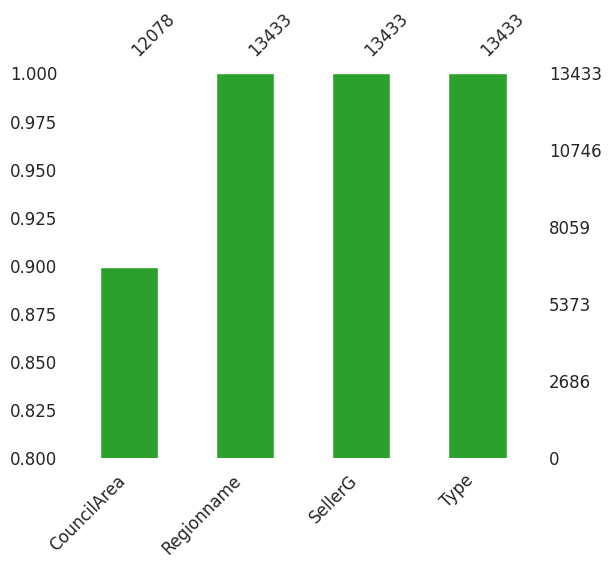

In [5]:
fig, axs = plt.subplots(figsize=(6, 5))
msno.bar(df[categorical_cols], sort="ascending", fontsize=12, color="tab:green", ax=axs)
axs.set_ylim(0.8, 1)
plt.show()

A continuación utilizamos la función OneHotEncoder de sklearn para realizar el One Hot Encoding de las variables. En el código se describe el paso a paso, pero la idea final es crear un nuevo DataFrame de Pandas con las nuevas columnas antes dichas.

In [6]:
# Nos quedamos con la columnas categóricas del DataFrame
features = df[categorical_cols]
# Creamos una lista con las categorías de cada variable categórica
categories = [features[column].unique() for column in features.columns]
# Inicializamos el enconder
encoder = OneHotEncoder(categories=categories)
# Mapeamos las categóricas a one-hot
encoded_features = encoder.fit_transform(features)

# Creación de nuevas columnas para one-hot
feature_names = []
for i, column in enumerate(features.columns):
    for category in categories[i]:
        feature_names.append(f'{column}_{category}')

encoded_df = pd.DataFrame(encoded_features.toarray(), columns=feature_names)
encoded_df.sample(10).T

,11165,8559,4710,1156,6433,11725,3686,6458,1993,7318
CouncilArea_Yarra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CouncilArea_Moonee Valley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CouncilArea_Port Phillip,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CouncilArea_Darebin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CouncilArea_Hobsons Bay,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
CouncilArea_Stonnington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CouncilArea_Boroondara,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CouncilArea_Monash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CouncilArea_Glen Eira,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CouncilArea_Whitehorse,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para finalizar este punto, unimos las variables numéricas originales con las categóricas codificadas.

In [7]:
new_df = pd.concat([encoded_df, df[numerical_cols]], axis=1)

new_df.sample(5).T

,12335,5633,6298,4595,6644
CouncilArea_Yarra,0.000000e+00,0.000000e+00,0.000000,0.0000,0.000000e+00
CouncilArea_Moonee Valley,0.000000e+00,0.000000e+00,0.000000,0.0000,0.000000e+00
CouncilArea_Port Phillip,0.000000e+00,0.000000e+00,0.000000,0.0000,0.000000e+00
CouncilArea_Darebin,0.000000e+00,0.000000e+00,0.000000,0.0000,0.000000e+00
CouncilArea_Hobsons Bay,0.000000e+00,0.000000e+00,0.000000,0.0000,0.000000e+00
CouncilArea_Stonnington,0.000000e+00,1.000000e+00,1.000000,0.0000,0.000000e+00
CouncilArea_Boroondara,0.000000e+00,0.000000e+00,0.000000,0.0000,0.000000e+00
CouncilArea_Monash,0.000000e+00,0.000000e+00,0.000000,0.0000,0.000000e+00
CouncilArea_Glen Eira,0.000000e+00,0.000000e+00,0.000000,0.0000,0.000000e+00
CouncilArea_Whitehorse,0.000000e+00,0.000000e+00,0.000000,0.0000,0.000000e+00


---
# Ejercicio 2 - Imputación por KNN

En este ejercicio trabajaremos sobre las variables numéricas, imputando de alguna manera en aquellos registros donde tengamos valores faltantes. Para empezar, creamos un DataFrame conteniendo las columnas de interés (todas menos aquellas que tienen información de AirBnB) y analizamos con `missingno`.

A partir del gráfico de barras vemos que YearBuilt y BuildingArea presentan datos faltantes 60(faltan el 40% y el 48%, respectivamnete). Luego, como el nuevo DataFrame está ordenado en función de BuildingArea, el gráfico de matriz nos muestra que hay una gran correlación entre los datos faltantes en estas 2 categorías bajo análisis: la gran mayoría de datos faltantes en YearBuilt se corresponden con datos faltantes en BuildingArea. Esta idea queda clara cuando pasamos al mapa de calor, el cual mide la correlación de nulidad: qué tan fuerte la presencia (o ausencia) de una variable afecta la presencia de otra. Las variables que están completamente llenas o completamente vacías no presentan correlación significativa, así que quedan automáticamente descartadas de la gráfica. Además, la gráfica sólo completa las correlaciones en la triangular inferior. La gráfica nos da un valor de 0.8, lo cual se interpreta de la siguiente manera: es altamente probable que cada vez que un registro tiene un valor no nulo en YearBuilt también tenga un valor no nulo BuildingArea.

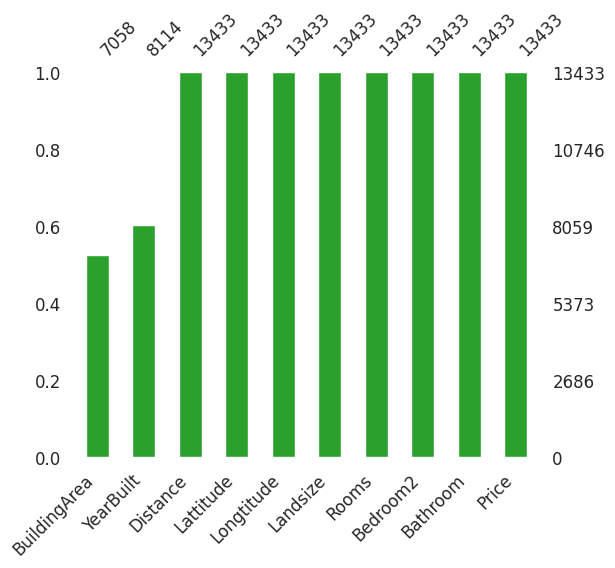

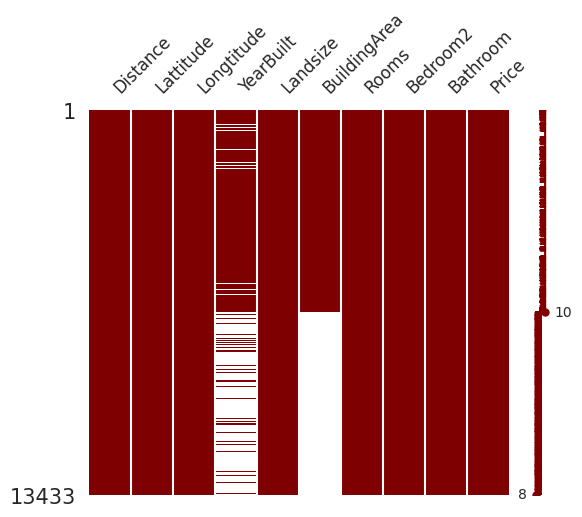

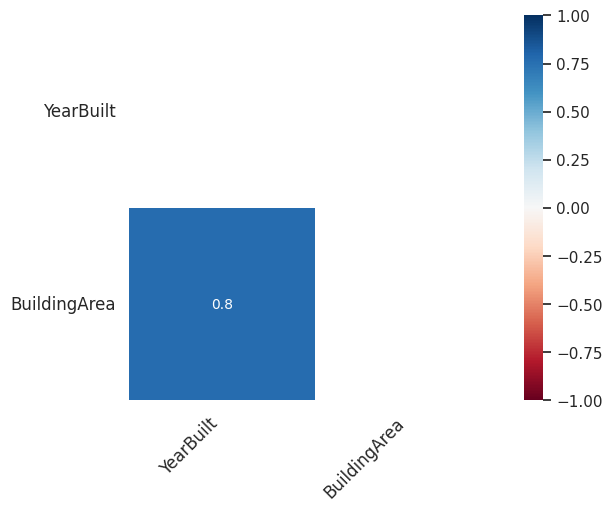

In [8]:
numcol_airless = [x for x in numerical_cols if (x.split('_')[0] != 'airbnb')]
df_airless = new_df[numcol_airless].sort_values('BuildingArea')

msno.bar(df_airless, sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
msno.matrix(df_airless, fontsize=12, color=[0.5,0,0], figsize=(6, 5))
msno.heatmap(df_airless, fontsize=12, figsize=(6, 5))

plt.show()

Ahora que sabemos dónde hay datos faltantes y sus posibles conexiones, vamos a pasar al tratamiento de los mismos, inclinándonos por el camino de la imputación. La técnica de imputación a utilizar se clasifica como avanzada, ya que reemplazaremos los datos faltantes por algún valor sustituto, estimado por un algortimso de  aprendizaje automático. Particularmente utilizaremos la imputación de vecinos más cercanos (KNN), el cual se basa en la *similitud de características* para predecir los valores de cualquier nuevo punto de datos. Esto significa que al nuevo punto se le asigna un valor en función de su parecido con los puntos del conjunto de entrenamiento, siendo muy útil para hacer predicciones sobre  valores faltantes al encontrar los k-vecinos más cercanos a la observación con datos perdidos y luego imputarlos en función de los valores no perdidos en el *vecindario*.

Particularmente, el imputador de sklearn que usaremos es un imputador multivariable, el cual modela cada característica que contiene valores faltantes como una función de otras características de manera rotatoria (hace todos-vs-todos).

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

df_knn = df_airless.copy(deep=True)

In [10]:
display(df_airless[['YearBuilt','BuildingArea']])

,YearBuilt,BuildingArea
13374,2010.0,0.0
13265,1980.0,0.0
12116,1970.0,0.0
13236,1965.0,0.0
13226,1920.0,0.0
...,...,...
13422,NaN,NaN
13423,NaN,NaN
13427,NaN,NaN
13428,1981.0,NaN


In [13]:
# Instanciamos el IterativeImputer con un estimador `KNeighborsRegressor`
# Además le damos una semilla fija
imputer = IterativeImputer(estimator=KNeighborsRegressor(), random_state=0,
                           max_iter=10, tol=1e-2, add_indicator=True)
# iterative imputer is sensible to the tolerance and
# dependent on the estimator used internally.
# we tuned the tolerance to keep this example run with limited computational
# resources while not changing the results too much compared to keeping the
# stricter default value for the tolerance parameter.
# tolerances = (1e-3, 1e-1, 1e-1, 1e-2)

df_knn[['YearBuilt','BuildingArea']] = imputer.fit_transform(df_knn[['YearBuilt', 'BuildingArea']])
display(df_knn[['YearBuilt','BuildingArea']])

13433


,YearBuilt,BuildingArea
13374,2010.0,0.0
13265,1980.0,0.0
12116,1970.0,0.0
13236,1965.0,0.0
13226,1920.0,0.0
...,...,...
13422,1953.0,77.0
13423,1953.0,77.0
13427,1953.0,77.0
13428,1981.0,162.8


In [ ]:
msno.bar(df_knn, sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
plt.show()

---

**OBSERVACIONES**
* THe version implemented assumes Gaussian (output) variables. If your features are obviously non-normal, consider transforming them to look more normal to potentially improve performance.
* A more sophisticated approach is to use the IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.
* The MissingIndicator transformer is useful to transform a dataset into corresponding binary matrix indicating the presence of missing values in the dataset. This transformation is useful in conjunction with imputation. When using imputation, preserving the information about which values had been missing can be informative. Note that both the SimpleImputer and IterativeImputer have the boolean parameter add_indicator (False by default) which when set to True provides a convenient way of stacking the output of the MissingIndicator transformer with the output of the imputer.
* Note that KNeighborsRegressor is different from KNN imputation, which learns from samples with missing values by using a distance metric that accounts for missing values, rather than imputing them.
* MSE --> smaller is better

---

### 2.3.2 Multivariate feature imputation 

Imputacion Multiple quiebra el problema de inferencia de los valores faltantes en tres pasos: 

- imputación

- análisis

- agrupación 

La imputación y el análisis puede realizarse  siguiendo el análisis estándar, pero la combinación debe realizarse siguiendo la regla de Rubin que da la fórmula para estimar la varianza total que se compone de la varianza dentro de la imputación y la varianza entre las diferentes imputaciones.

Imputación multiple por ecuaciones encadenadas (MICE) es una estrategia para imputar valores faltantes modelando cada característica con valores perdidos como una función de otras características en forma rotatoria. Realiza regresiones múltiples sobre una muestra aleatoria de los datos, luego toma el promedio de los valores de regresión múltiple y usa ese valor para imputar el valor faltante. 

Este tipo de imputación funciona llenando los datos faltantes varias veces. Las imputaciones múltiples (IM) son mucho mejores que una sola imputación, ya que mide la incertidumbre de los valores perdidos de una mejor manera. El enfoque de ecuaciones encadenadas también es muy flexible y puede manejar diferentes variables de diferentes tipos de datos (es decir, continuos o binarios), así como complejidades como límites o patrones de omisión de encuestas.

La version de Sklearn no permite trabajar con variables de distinto tipo, hay que realizar encoding. 

Ver pros y cons, este no dice que deba ser estandarizado

In [ ]:
melb_data_mice = melb_df.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=BayesianRidge())

melb_data_mice[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(melb_data_mice[['YearBuilt','BuildingArea']])



melb_data_mice.sample(10)
    

---

---

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

Ejemplo de gráfico comparando las distribuciones de datos obtenidas con cada método de imputación.

In [ ]:
mice_year_built = df_knn.YearBuilt.to_frame()
mice_year_built['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_year_build = df_airless.YearBuilt.dropna().to_frame()
melb_year_build['Imputation'] = 'Original'
data = pd.concat([mice_year_built, melb_year_build])
fig = plt.figure(figsize=(8, 5))
g = sns.kdeplot(data=data, x='YearBuilt', hue='Imputation')
fig = plt.figure(figsize=(8, 5))
g = sns.kdeplot(data=data, x='BuildingArea', hue='Imputation')

---
# Ejercicio 3 - Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

---
# Ejercicio 4 - Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

In [ ]:
## Small example
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

## If we process our data with the following steps:
categorical_cols = ['Type', 'Regionname']
numerical_cols = ['Rooms', 'Distance']
new_columns = []

# Step 1: encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = encoder.fit_transform(melb_df[categorical_cols])
for col, col_values in zip(categorical_cols, encoder.categories_):
  for col_value in col_values:
    new_columns.append('{}={}'.format(col, col_value))
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 2: Append the numerical columns
X = numpy.hstack([X_cat, melb_df[numerical_cols].values])
new_columns.extend(numerical_cols)
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 3: Append some new features, like PCA
pca = PCA(n_components=2)
pca_dummy_features = pca.fit_transform(X)
X_pca = numpy.hstack([X, pca_dummy_features])
new_columns.extend(['pca1', 'pca2'])

## Re-build dataframe
processed_melb_df = pandas.DataFrame(data=X_pca, columns=new_columns)
processed_melb_df.head()

---
# Ejercicio 5 - Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más 
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de 
     publicaciones de la plataforma AirBnB en el mismo código 
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el 
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```
